In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Set display options to show more rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect the display width
pd.set_option('display.max_colwidth', None)  # Show full content of each column


### <font color="orange">  **Data Loading, Preprocessing** </font>

In [2]:
df = pd.read_csv('health_insurance_train.csv')
df_autograder = pd.read_csv('health_insurance_autograde.csv')
pd.options.display.float_format = '{:.2f}'.format

# Define a function to convert education ranges to numerical values
def convert_education(education):

    education = education.replace('years', '')

    if '>16' in education:
        return 20
    
    if '<9' in education:
        return 4.5

    education = education.split('-')
    education = (float(education[-1])+float(education[0]))/2

    return education

# Define a function to convert yes/no values to binary values
def yes_no_True_False_to_binary(value):
    if value == 'yes' or value == 'no':
        if value == 'yes':
            return 1
        else:
            return -1
        
    if value == True or value == False:
        if value == True:
            return 1
        else:
            return 0

    return value

# Define a function to convert NaN values to the mean of the column
def nan_to_mean(value, mean):
    if pd.isna(value):
        return mean
    return value

# Define a function apply all conversion functions to the dataframe
def preprocess_data(df):
    # Apply the conversion functions to the education column
    df['education'] = df['education'].apply(convert_education)

    # Apply one-hot encoding to the race and region column

    ''''
    One hot encoding is a process by which categorical variables are converted into
    binary True/False. ML algorithm will read True as 1 and False as 0. So gradients
    can be made for each column separetely.

    '''
    df = pd.get_dummies(df, columns=['race'], prefix='race')
    df = pd.get_dummies(df, columns=['region'],prefix='reg')
    df = pd.get_dummies(df, columns=['hispanic'],prefix='hisp')


    # Apply binary conversion to all remaining columns that contain yes/no or True/False values
    for key in df.keys():
        df[key] = df[key].apply(yes_no_True_False_to_binary)

    # Apply the mean conversion to all columns that contain NaN values
    ''''
    Now that all columns are already converted to numerical values, we can apply the
    mean conversion to all columns that contain NaN values.

    '''

    for key in df:
        mean = df[key].mean()
        df[key] = df[key].apply(lambda x: nan_to_mean(x, mean))

    return df

df_pp = preprocess_data(df)
df_autograder_pp = preprocess_data(df_autograder)

In [3]:
df_pp.head()

,whrswk,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,40.00,-1,1,1,14.00,17.00,0.00,1.00,22.00,0,0,1,0,0,1,0,1,0
1,40.00,-1,1,1,14.00,4.00,1.00,0.00,15.00,0,0,1,0,0,1,0,1,0
2,0.00,1,-1,1,16.00,21.00,0.00,1.00,100.00,0,0,1,0,1,0,0,1,0
3,40.00,-1,-1,1,14.00,22.00,0.34,0.70,60.00,0,0,1,1,0,0,0,1,0
4,35.00,-1,1,-1,12.00,15.00,0.00,2.00,0.00,0,0,1,0,0,1,0,1,0


In [4]:
df_autograder_pp.head()

,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,-1,1,-1,16.00,25.00,0.00,0.00,0.00,0,0,1,0,0,0,1,1,0
1,-1,-1,-1,12.00,41.00,0.00,0.00,0.00,0,0,1,0,0,1,0,1,0
2,1,1,1,20.00,21.00,0.00,2.00,34.30,0,0,1,0,1,0,0,1,0
3,-1,1,1,10.00,46.50,0.00,0.00,0.00,0,0,0,0,1,0,0,1,0
4,-1,-1,-1,14.00,9.00,0.00,0.00,25.00,0,0,1,1,0,0,0,1,0


In [5]:
########### Pipeline Configuration ##############
specific_scaling = True
filter_outliers = True
consider_regular_employee_margin = True
consider_unenployee_margin = True


#Pipeline 1 --> False,False
#Pipeline 2 --> True,True
#################################################


### <font color="orange">  **Scaling** </font>

In [6]:
df_pp_mean = df_pp.mean(axis=0)
df_pp_std = df_pp.std(axis=0)

Y_mean = df_pp_mean[0]
Y_std = df_pp_std[0]

if specific_scaling:
    def scale_specifically(df, mean, std, columns_index=[0, 4, 5, 6, 7, 8]):
        df_scaled = df.copy()
        for i in range(len(df.columns)):
            if i in columns_index:
                df_scaled.iloc[:, i] = (df_scaled.iloc[:, i] - mean.iloc[i]) / std.iloc[i]
        return df_scaled


    df_scaled = scale_specifically(df_pp, df_pp_mean, df_pp_std, columns_index=[0, 4, 5, 6, 7, 8])
    df_autograder_scaled = scale_specifically(df_autograder_pp, df_pp_mean.iloc[1:], df_pp_std.iloc[1:], columns_index=[3,4,5,6,7])

else:
    df_scaled = (df_pp - df_pp_mean) / df_pp_std
    df_autograder_scaled = (df_autograder_pp - df_pp_mean.iloc[1:]) / df_pp_std.iloc[1:]

C:\Users\yanca\AppData\Local\Temp\ipykernel_7100\1981104028.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_mean = df_pp_mean[0]
C:\Users\yanca\AppData\Local\Temp\ipykernel_7100\1981104028.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_std = df_pp_std[0]


In [7]:
df_scaled.head()

,whrswk,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,0.77,-1,1,1,0.28,-0.51,-0.55,0.31,-0.22,0,0,1,0,0,1,0,1,0
1,0.77,-1,1,1,0.28,-1.63,1.07,-0.75,-0.52,0,0,1,0,0,1,0,1,0
2,-1.37,1,-1,1,0.92,-0.16,-0.55,0.31,3.06,0,0,1,0,1,0,0,1,0
3,0.77,-1,-1,1,0.28,-0.08,0.00,-0.00,1.38,0,0,1,1,0,0,0,1,0
4,0.50,-1,1,-1,-0.36,-0.68,-0.55,1.37,-1.15,0,0,1,0,0,1,0,1,0


In [8]:
df_autograder_scaled.head()

,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,-1,1,-1,0.92,0.18,-0.55,-0.75,-1.15,0,0,1,0,0,0,1,1,0
1,-1,-1,-1,-0.36,1.57,-0.55,-0.75,-1.15,0,0,1,0,0,1,0,1,0
2,1,1,1,2.20,-0.16,-0.55,1.37,0.30,0,0,1,0,1,0,0,1,0
3,-1,1,1,-0.99,2.04,-0.55,-0.75,-1.15,0,0,0,0,1,0,0,1,0
4,-1,-1,-1,0.28,-1.20,-0.55,-0.75,-0.10,0,0,1,1,0,0,0,1,0


   whrswk  hhi  whi  hhi2  education  experience  kidslt6  kids618  husby  \
0    0.77   -1    1     1       0.28       -0.51    -0.55     0.31  -0.22   
1    0.77   -1    1     1       0.28       -1.63     1.07    -0.75  -0.52   
2   -1.37    1   -1     1       0.92       -0.16    -0.55     0.31   3.06   
3    0.77   -1   -1     1       0.28       -0.08     0.00    -0.00   1.38   
4    0.50   -1    1    -1      -0.36       -0.68    -0.55     1.37  -1.15   

   race_black  race_other  race_white  reg_northcentral  reg_other  reg_south  \
0           0           0           1                 0          0          1   
1           0           0           1                 0          0          1   
2           0           0           1                 0          1          0   
3           0           0           1                 1          0          0   
4           0           0           1                 0          0          1   

   reg_west  hisp_no  hisp_yes  mahalanobis  
0   

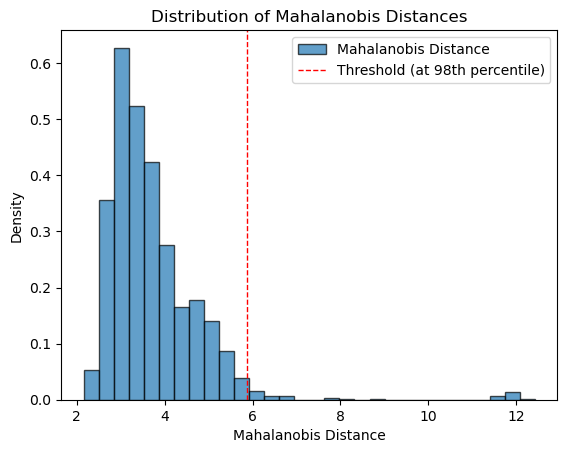

Outliers found
Number of outliers: 80


In [9]:

fraction = 0.2  # 20% of the rows
df_unseen = df_scaled.sample(frac = fraction, random_state=42)

# Get the remaining 80% of the rows
df_seen = df_scaled.drop(df_unseen.index)


if filter_outliers:
    
    df_filtered = df_seen.copy()
    df_numeric = df_filtered.select_dtypes(include=[np.number]) # Select only numerical columns

    # Calculate the mean vector and covariance matrix
    mean_vector = df_numeric.mean(axis=0)
    cov_matrix = np.cov(df_numeric.values.T)

    # Add a small regularization term to the covariance matrix such that it's not singular
    # Since we are using classification data, 
    regularization_term = 1e-5 * np.eye(cov_matrix.shape[0])
    cov_matrix += regularization_term


    #--------- Compute the Mahalanobis distance for each observation
    def mahalanobis_distance(row, mean_vector, cov_matrix):

        '''
        The Mahalanobis distance assumes that the data follows a multivariate normal distribution. 

        1. Calculate the difference vector (diff) between the observation and the mean.
        2. Transpose the difference vector (diff.T).
        3. Multiply the transposed difference vector by the inverse covariance matrix (diff.T @ inv_cov_matrix).
        4. Multiply the result by the original difference vector (diff.T @ inv_cov_matrix @ diff).
        5. Take the square root of the result to get the Mahalanobis distance (md).
        '''

        diff = row - mean_vector
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        md = np.sqrt(diff.T @ inv_cov_matrix @ diff) 
        return md

    # Apply the Mahalanobis distance function to each row
    # lamda makes row is a anonymous function that takes a single argument row, it is necessary to pass row as an argument to .apply
    # What apply sees is a function that takes a single argument, so it passes each row to this function
    df_filtered['mahalanobis'] = df_numeric.apply(lambda row: mahalanobis_distance(row, mean_vector, cov_matrix), axis=1) 
    print(df_filtered.head())

    #--------- Determine the threshold for identifying outliers
    percentile = 98
    threshold = np.percentile(df_filtered['mahalanobis'], percentile)
    print(f"Threshold (at {percentile}th percentile): {threshold}")


    # Plot the distribution of Mahalanobis distances
    plt.hist(df_filtered['mahalanobis'], bins=30, edgecolor='k', alpha=0.7, density=True, label='Mahalanobis Distance')

    # Add the threshold line
    plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label=f'Threshold (at {percentile}th percentile)')

    # Add titles and labels
    plt.title('Distribution of Mahalanobis Distances')
    plt.xlabel('Mahalanobis Distance')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Identify outliers
    outliers = df_filtered[df_filtered['mahalanobis'] > threshold]
    
    if not outliers.empty:
        print("Outliers found")
        print(f"Number of outliers: {len(outliers)}")
    else:
        print("No outliers found")
    
    # Filter out the rows that contain outliers
    df_filtered = df_filtered[df_filtered['mahalanobis'] <= threshold]

    # Drop the 'mahalanobis' column as it's no longer needed
    df_filtered.drop(columns=['mahalanobis'], inplace=True)

else: 
    df_filtered = df_seen


In [10]:
# if brute_force_uniform_distribution:
#     import math
#     # Define the interval for subgroups
#     interval = 0.2

#     # Create subgroups based on 'whrswk' for every 0.2 interval
#     subgroups = {}
#     min_whrswk = df_filtered['whrswk'].min()
#     max_whrswk = df_filtered['whrswk'].max()
    
#     # Create subgroups
#     for start in np.arange(min_whrswk, max_whrswk, interval):
#         end = start + interval
#         subgroup = df_filtered[(df_filtered['whrswk'] >= start) & (df_filtered['whrswk'] < end)]
#         subgroups[(start, end)] = subgroup

#     # Find the size of the largest subgroup
#     max_size = max(len(subgroup) for subgroup in subgroups.values())

#     # Balance each subgroup to match the size of the largest subgroup
#     balanced_subgroups = []
#     for key, subgroup in subgroups.items():
#         if len(subgroup) == 0:
#             continue
#         repeat_times = math.ceil(max_size / len(subgroup))
#         balanced_subgroup = pd.concat([subgroup] * repeat_times, ignore_index=True)
#         balanced_subgroup = balanced_subgroup.iloc[:max_size]
#         balanced_subgroups.append(balanced_subgroup)

#     # Concatenate all balanced subgroups
#     df_uniform = pd.concat(balanced_subgroups, ignore_index=True)

#     print(f"Size of largest subgroup: {max_size}")
#     print(f"Size of balanced dataframe: {len(df_uniform)}")

#     # Calculate the bin edges based on the interval
#     bin_edges = np.arange(min_whrswk, max_whrswk + interval, interval)

#     # Plot the histogram with the calculated bin edges
#     plt.hist(df_uniform['whrswk'], bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Balanced Data')

#     # Add vertical lines to mark the division intervals
#     for edge in bin_edges:
#         plt.axvline(x=edge, color='r', linestyle='--', linewidth=1)
        
#     plt.legend()
#     plt.show()
    
# else:
#     df_uniform = df_filtered

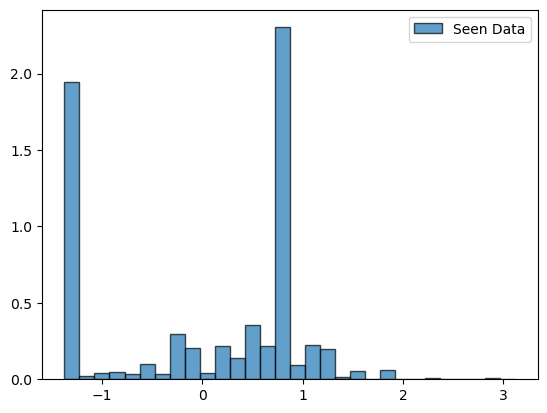

In [11]:
from sklearn.model_selection import train_test_split

X_seen = df_filtered.iloc[:, 1:]
Y_seen = df_filtered.iloc[:, 0]

X_unseen = df_unseen.iloc[:, 1:]
Y_unseen = df_unseen.iloc[:, 0]

X_autograder = df_autograder_scaled

plt.hist(Y_seen, bins=30, edgecolor='k', alpha=0.7, density=True, label='Seen Data')
plt.legend()



### <font color="orange">  **Dummy model** </font>

In [12]:
from sklearn.dummy import DummyRegressor

def train_dummy_predictor(X, Y):
    model = DummyRegressor(strategy='mean')
    model.fit(X, Y)
    return model

### <font color="orange">  **KNN** </font>

In [13]:
from sklearn.neighbors import KNeighborsRegressor

def train_knn_regressor(X, Y, param_grid):
    model = KNeighborsRegressor(**param_grid)
    model.fit(X, Y)
    Y_pred = model.predict(X)
    loss_values = [mean_absolute_error(Y, Y_pred)]
    return model,loss_values

### <font color="orange">  **SGD** </font>

In [14]:
from sklearn.linear_model import SGDRegressor

def train_sgd_regressor(X, Y, params):
    model = SGDRegressor(**params)

    epochs = params['max_iter']

    params['warm_start'] = True
    params['max_iter'] = 1


    loss_values = []
    for epoch in range(epochs):
        model.partial_fit(X, Y)
        Y_pred = model.predict(X)
        epoch_loss = mean_absolute_error(Y, Y_pred)
        loss_values.append(epoch_loss)
    
    return model, loss_values

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

def train_decision_tree_regressor(X, Y, params):

    '''params : dict
        Dictionary of parameters to pass to DecisionTreeRegressor.'''
    
    # splitter = Supported strategies are "best" to choose the best split and "random" to choose the best random split.
    # max_features = The number of features to consider when looking for the best split
    # min_samples_split = The minimum number of samples required to split an internal node
    # min_samples_leaf = The minimum number of samples required to be at a leaf node

    model = DecisionTreeRegressor(**params)
    loss_values = []
    
    # Custom training loop with logging
    for depth in range(1, params['max_depth'] + 1):
        model.set_params(max_depth=depth)
        model.fit(X, Y)
        Y_pred = model.predict(X)
        loss = mean_absolute_error(Y, Y_pred)
        loss_values.append(loss)
    
    return model, loss_values

### <font color="orange">  **Grid Search** </font>

In [16]:
def grid_search(X, Y, model, param_grid, cv=5):
    
    # cv = It determines the cross-validation splitting strategy used to evaluate the performance of the model for each combination of hyperparameters
    # This means that the dataset will be split into 5 parts (folds). The model will be trained on 4 parts and tested on the remaining part.
    # This process will be repeated 5 times, each time with a different part as the test set.
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    # Fit the model
    print("Working on grid search")
    grid_search.fit(X, Y)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"Best parameters: {best_params}")
    
    return best_model, best_params


X_train, X_val, Y_train, Y_val = train_test_split(X_seen, Y_seen, test_size=0.2, random_state=42)

####################################################################
# ------ KNN REGRESSOR
print("------ KNN Regressor -----")
param_grid_KNN = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15 , 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

model = KNeighborsRegressor()
best_model, best_params_KNN =  grid_search(X_train, Y_train, model, param_grid_KNN, cv=5)

####################################################################
# ------ DECISION TREE REGRESSOR
print("------ Decision Tree Regressor -----")
param_grid_Tree = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'splitter': ['best', 'random'],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

model = DecisionTreeRegressor()
best_model, best_params_tree =  grid_search(X_train, Y_train, model, param_grid_Tree, cv=5)

####################################################################
# ------ SGD REGRESSOR
print("------ SGD Regressor -----")
param_grid_SGD = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.00001,0.0001], 'max_iter': [25,50,100, 200]
}

# penaulty = the regularization term to prevent overfitting
# alpha = the learning rate
# max_iter = the number of iterations to run the model
# warm_start = allows the model to continue training from the previous iteration
# tol = the stopping criterion
# List to store the loss values

model = SGDRegressor()
best_model, best_params_SGD =  grid_search(X_train, Y_train, model, param_grid_SGD, cv=5)


------ KNN Regressor -----
Working on grid search
Best parameters: {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
------ Decision Tree Regressor -----
Working on grid search
Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 5, 'splitter': 'random'}
------ SGD Regressor -----
Working on grid search
Best parameters: {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'adaptive', 'max_iter': 100, 'penalty': 'l2'}


### <font color="orange">  **Model training** </font>

In [17]:
print(f"Max Y_seen value: {Y_seen.max()}")
print(f"Min Y_seen value: {Y_seen.min()}")
print(f"Mean Y_seen value: {Y_seen.mean()}")
print("\n")


####################################################################
# ------ DUMMY PREDICTOR
print("------ Dummy Predictor -----")
model = train_dummy_predictor(X_train, Y_train)
Y_pred = model.predict(X_val)

loss = mean_absolute_error(Y_val, Y_pred)
print(f"Val Loss: {loss:.4f}")
print("\n")

Max Y_seen value: 3.1178705210175255
Min Y_seen value: -1.372319745743416
Mean Y_seen value: 0.010164673670935811


------ Dummy Predictor -----
Val Loss: 0.9033




In [18]:
####################################################################
# ------ KNN REGRESSOR
print("------ KNN Regressor -----")
KNN_model, loss_values = train_knn_regressor(X_train, Y_train, best_params_KNN)
Y_pred_KNN = KNN_model.predict(X_val)

loss = mean_absolute_error(Y_val, Y_pred_KNN)
print(f"Val Loss: {loss:.4f}")
print("\n")

------ KNN Regressor -----
Val Loss: 0.6095




In [20]:
####################################################################
# ------ Decision Tree Regressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz

print("------ Decision Tree Regressor -----")
Tree_model, loss_values = train_decision_tree_regressor(X_train, Y_train, best_params_tree)
Y_pred_Tree = Tree_model.predict(X_val)

loss = mean_absolute_error(Y_val, Y_pred_Tree)
print(f"Val Loss: {loss:.4f}")
print("\n")

# Export the decision tree to a DOT file
dot_data = export_graphviz(Tree_model, out_file=None, 
                           feature_names=X_train.columns,  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Convert the DOT file to a PDF
graph = graphviz.Source(dot_data)  
graph.render("decision_tree", format='pdf')

# Manually add a color legend to the DOT file
dot_data += """
    subgraph cluster_legend {
        label="Target Value Legend";
        key [label=<
            <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4">
                <TR><TD BGCOLOR="#e5f5e0">Low</TD></TR>
                <TR><TD BGCOLOR="#a1d99b">Medium</TD></TR>
                <TR><TD BGCOLOR="#31a354">High</TD></TR>
            </TABLE>
        >];
        key2 [label=""];
    }
"""

------ Decision Tree Regressor -----
Val Loss: 0.5876




'decision_tree.pdf'

------ SGD Regressor -----
Val Loss: 0.6272


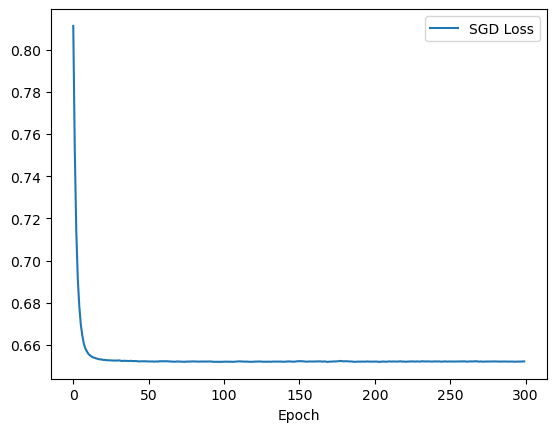

In [123]:
####################################################################
# ------ SGD Regressor
print("------ SGD Regressor -----")
SGD_model, loss_values = train_sgd_regressor(X_train, Y_train, best_params_SGD)
Y_pred_SGD = SGD_model.predict(X_val)

loss = mean_absolute_error(Y_val, Y_pred_SGD)
print(f"Val Loss: {loss:.4f}")

plt.plot(loss_values, label='SGD Loss')
plt.xlabel('Epoch')
plt.legend()

In [ ]:
####################################################################
plt.hist(Y_val, bins=30, edgecolor='k', alpha=0.7, density=True, label='Val Data')
plt.hist(Y_pred_KNN, bins=30, edgecolor='k', alpha=0.7, density=True, label='KNN Prediction')
plt.hist(Y_pred_Tree, bins=30, edgecolor='k', alpha=0.7, density=True, label='Decision Tree Prediction')
plt.hist(Y_pred_SGD, bins=30, edgecolor='k', alpha=0.7, density=True, label='SGD Prediction')
plt.legend()

### <font color="orange">  **Ensemble training** </font>

In [117]:

def train_models(X_seen,Y_seen,param_grid, model, model_train_function, n_models = 10, val_size = 0.2):

    models_training_loss = []
    model_list = []

    # Use grid search to find the best hyperparameters only once
    best_model, best_param = grid_search(X_seen, Y_seen, model, param_grid, cv=5)

    for n in range(n_models):
        
        X_train, X_val, Y_train, Y_val = train_test_split(X_seen, Y_seen, test_size= val_size, random_state= 42*n)

        print(f"Training model {n+1}")
        model, loss_values = model_train_function(X_train, Y_train, best_param)

        model_list.append(model)
        models_training_loss.append(loss_values)

        Y_pred = model.predict(X_val)

        loss = mean_absolute_error(Y_val, Y_pred)

        print(f"Val Loss: {loss:.4f}")
    
    return model_list, models_training_loss


### <font color="orange">  **Ensemble validation** </font>

Working on grid search
Best parameters: {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'adaptive', 'penalty': 'l2'}
Training model 1
Val Loss: 0.6656
Training model 2
Val Loss: 0.6272
Training model 3
Val Loss: 0.6481
Training model 4
Val Loss: 0.6656
Training model 5
Val Loss: 0.6271
Training model 6
Val Loss: 0.6526
Training model 7
Val Loss: 0.6483
Training model 8
Val Loss: 0.6508
Training model 9
Val Loss: 0.6805
Training model 10
Val Loss: 0.6553


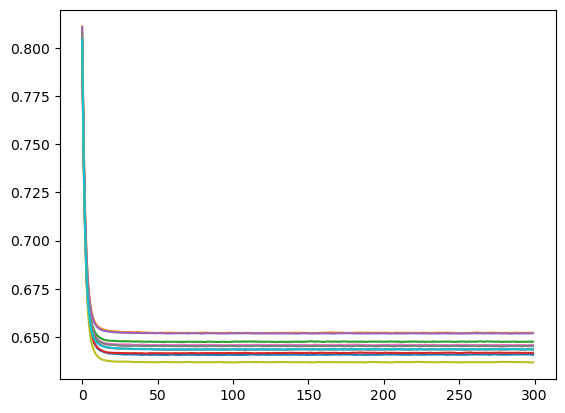

In [118]:
#############################
# ------SGD REGRESSOR

param_grid_SGD = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.00001,0.0001]
}

model = SGDRegressor()
model_list_SGD, models_training_loss = train_models(X_seen, Y_seen, param_grid_SGD, model, train_sgd_regressor)
##############################

for loss_values in models_training_loss:
    plt.plot(loss_values)


In [119]:
#############################
# ------KNN REGRESSOR
param_grid_KNN = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

model = KNeighborsRegressor()
model_list_KNN, models_training_loss = train_models(X_seen, Y_seen, param_grid_KNN, model, train_knn_regressor)

##############################

Working on grid search
Best parameters: {'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
Training model 1
Val Loss: 0.6273
Training model 2
Val Loss: 0.6047
Training model 3
Val Loss: 0.6244
Training model 4
Val Loss: 0.6380
Training model 5
Val Loss: 0.6139
Training model 6
Val Loss: 0.6160
Training model 7
Val Loss: 0.6253
Training model 8
Val Loss: 0.6024
Training model 9
Val Loss: 0.6313
Training model 10
Val Loss: 0.6162


### <font color="orange">  **Esemble test** </font>

In [120]:
def esemble_test(model_list, X_unseen, Y_unseen):
    loss_list = []
    for model in model_list:
        Y_pred = model.predict(X_unseen)

        if consider_unenployee_margin:
            for i in range(len(Y_pred)):
                if Y_pred[i] >= -2 and Y_pred[i] <= -0.5:
                    Y_pred[i] = -1.37

        if consider_regular_employee_margin:
            for i in range(len(Y_pred)):
                if Y_pred[i] >= 0.5 and Y_pred[i] <= 1:
                    Y_pred[i] = 0.77
                
        loss_list.append(mean_absolute_error(Y_unseen, Y_pred))
    
    avg_loss = np.mean(loss_list)
    return avg_loss



KNN_avg_test_loss = esemble_test(model_list_KNN, X_unseen, Y_unseen)
print(f"KNN - Test Loss: {KNN_avg_test_loss:.4f}")

SGD_avg_test_loss = esemble_test(model_list_SGD, X_unseen, Y_unseen)
print(f"SGD - Test Loss: {SGD_avg_test_loss:.4f}")




    

KNN - Test Loss: 0.5879
SGD - Test Loss: 0.6027
